In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.ndimage as nd
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

plt.rcParams["image.cmap"] = "gist_gray"

In [2]:
# --- locations of pictures
dpath  = "pictures"
training_path_full = "/Users/geoffperrin/Desktop/CUSP/capstone/computer_vision/training_pictures"
training_path = 'training_pictures'

In [3]:
os.getcwd()

'/Users/geoffperrin/Desktop/CUSP/capstone/computer_vision'

In [4]:
# -- get path to images
stpath = os.path.join(training_path, "*.jpg")
stlist = sorted(glob.glob(stpath))
nstamp = len(stlist)

In [5]:
stlist

['training_pictures/defect_neg_100.jpg',
 'training_pictures/defect_neg_101.jpg',
 'training_pictures/defect_neg_102.jpg',
 'training_pictures/defect_neg_103.jpg',
 'training_pictures/defect_neg_104.jpg',
 'training_pictures/defect_neg_105.jpg',
 'training_pictures/defect_neg_106.jpg',
 'training_pictures/defect_neg_107.jpg',
 'training_pictures/defect_neg_108.jpg',
 'training_pictures/defect_neg_109.jpg',
 'training_pictures/defect_neg_110.jpg',
 'training_pictures/defect_neg_111.jpg',
 'training_pictures/defect_neg_112.jpg',
 'training_pictures/defect_neg_113.jpg',
 'training_pictures/defect_neg_119.jpg',
 'training_pictures/defect_neg_120.jpg',
 'training_pictures/defect_neg_121.jpg',
 'training_pictures/defect_neg_122.jpg',
 'training_pictures/defect_neg_123.jpg',
 'training_pictures/defect_neg_124.jpg',
 'training_pictures/defect_neg_125.jpg',
 'training_pictures/defect_neg_126.jpg',
 'training_pictures/defect_neg_127.jpg',
 'training_pictures/defect_neg_128.jpg',
 'training_pictu

In [7]:
x = nd.imread('/Users/geoffperrin/Desktop/CUSP/capstone/computer_vision/training_pictures/defect_pos_70.jpg')
x.shape

(50, 50, 4)

# (NOTE 8-8-17): Right now, I'm stuck on reading in these images - Greg originally read them in as pickled objects, seems inappropriate here. But maybe I should save them as pickles, idk

In [42]:
# -- set a shuffle index
np.random.seed(314)
sind = np.random.rand(nstamp).argsort()

# -- read the postage stamps and shuffle
image_list = []
image_list.append([nd.imread(i)[1:-1, 1:-1] for i in stlist])
image_list_shuffled = np.array([nd.imread(i)[1:-1, 1:-1] for i in stlist])[sind]

# -- set the labels
labels = np.array([[1.0, 0.0] if "pos" in i  else [0.0, 1.0] for i in stlist]).astype(np.float32)[sind]

In [49]:
nstamp = len(stlist)
npix   = image_list_shuffled.shape[1]**2
nside  = int(np.sqrt(npix))

In [58]:
print nstamp, npix, nside

479 2304 48


In [59]:
np.arange(2304).reshape((48, 48))

array([[   0,    1,    2, ...,   45,   46,   47],
       [  48,   49,   50, ...,   93,   94,   95],
       [  96,   97,   98, ...,  141,  142,  143],
       ..., 
       [2160, 2161, 2162, ..., 2205, 2206, 2207],
       [2208, 2209, 2210, ..., 2253, 2254, 2255],
       [2256, 2257, 2258, ..., 2301, 2302, 2303]])

In [61]:
image_list_shuffled.shape

(479, 48, 48, 4)

### Cracks!

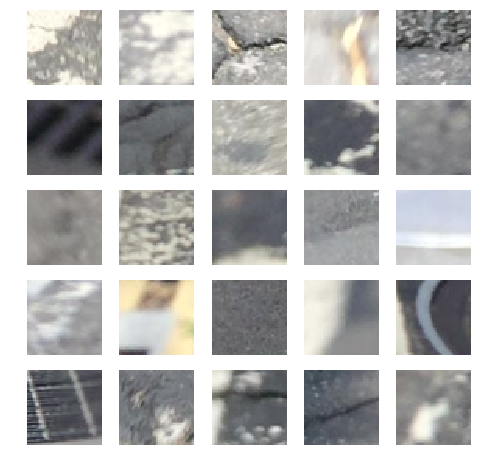

In [73]:
nax = 5
fig, ax = plt.subplots(nax, nax, figsize=(8, 8))
[ax[ii // nax, ii % nax].axis("off") for ii in range(nax * nax)]
[ax[ii // nax, ii % nax].imshow(image_list_shuffled[labels[:, 0] == 1][ii]) for ii in range(nax * nax)]
fig.canvas.draw()

### Smooth!

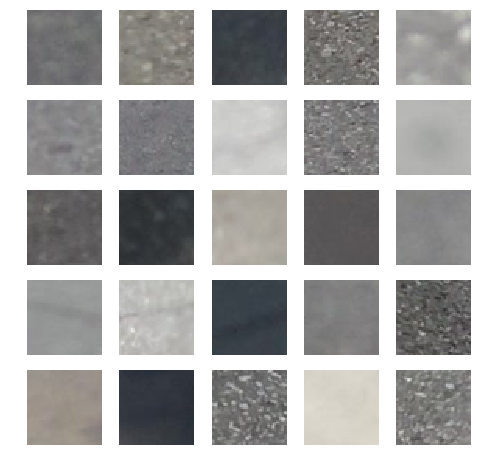

In [74]:
nax = 5
fig, ax = plt.subplots(nax, nax, figsize=(8, 8))
[ax[ii // nax, ii % nax].axis("off") for ii in range(nax * nax)]
[ax[ii // nax, ii % nax].imshow(image_list_shuffled[labels[:, 0] == 0][ii]) for ii in range(nax * nax)]
fig.canvas.draw()

### Building the CNN
The data is now in **exactly** the same form as the MNIST data was, and so we can apply the same model:

In [75]:
# -- prototype weight and bias variables
def weight_variable(shape):
    """ Initialize a variable with Gaussian noise."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """ Initialize a variable with a constant value."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


# -- prototype convolutional and pooling functions
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")


# -- define data prototypes and reshape input
x       = tf.placeholder(tf.float32, shape=[None, npix])
y_      = tf.placeholder(tf.float32, shape=[None, 2]) # only two possibilities car vs not car
x_image = tf.reshape(x, [-1, 48, 48, 1]) # last channel is color channel


# -- first layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)


# -- second layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


# -- fully connected layer
W_fc1        = weight_variable([12 * 12 * 64, 1024]) # this is why 48x48 instead of 50x50
b_fc1        = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 12 * 12 * 64])
h_fc1        = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


# -- dropout
keep_prob  = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


# -- output layer
W_fc2  = weight_variable([1024, 2])
b_fc2  = bias_variable([2])
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

---

### Training the CNN

Again, we can train exactly as before.  The only difference is that we need a training and testing set, so let's do a 70/30 split.